# pyPCGA stwave inversion example

In [1]:
%matplotlib inline

- import relevant python packages after installing pyPCGA
- stwave.py includes python wrapper to stwave model

In [2]:
import matplotlib.pyplot as plt 
from scipy.io import savemat, loadmat
import numpy as np
import stwave as st
from pyPCGA import PCGA
import math
import datetime as dt

- model domain and discretization

In [3]:
N = np.array([110,83])
m = np.prod(N) 
dx = np.array([5.,5.])
xmin = np.array([0. + dx[0]/2., 0. + dx[1]/2.])
xmax = np.array([110.*5. - dx[0]/2., 83.*5. - dx[1]/2.])

- covariance kernel and scale parameters following Hojat's CSKF paper

In [4]:
prior_std = 1.5
prior_cov_scale = np.array([18.*5., 18.*5.])
def kernel(r): return (prior_std**2)*np.exp(-r**2)

- grid coordinates for plotting purposes

In [5]:
x = np.linspace(0. + dx[0]/2., 110*5 - dx[0]/2., N[0])
y = np.linspace(0. + dx[1]/2., 83*5 - dx[0]/2., N[1])
XX, YY = np.meshgrid(x, y)
pts = np.hstack((XX.ravel()[:,np.newaxis], YY.ravel()[:,np.newaxis]))

- load data, true field is optional

In [6]:
obs = np.loadtxt('obs.txt')
s_true = np.loadtxt('true_depth.txt')

- define domain extent, discretization and measurement collection time

In [7]:
nx = 110
ny = 83
Lx = 550
Ly = 415
x0, y0 = (62.0, 568.0)
t1 = dt.datetime(2015, 10, 07, 20, 00)
t2 = dt.datetime(2015, 10, 07, 21, 00)

stwave_params = {'nx': nx, 'ny': ny, 'Lx': Lx, 'Ly': Ly, 'x0': x0, 'y0': y0, 't1': t1, 't2': t2,
          'offline_dataloc': "./input_files/8m-array_2015100718_2015100722.nc"}

- prepare interface to run stwave as a function

In [8]:
def forward_model(s,parallelization,ncores = None):
    # initialize stwave
    model = st.Model(stwave_params)
    
    if parallelization:
        simul_obs = model.run(s,parallelization,ncores)
    else:
        simul_obs = model.run(s,parallelization)
    return simul_obs

- PCGA inversion parameters

In [9]:
params = {'R':(0.1)**2, 'n_pc':50,
          'maxiter':10, 'restol':0.01,
          'matvec':'FFT','xmin':xmin, 'xmax':xmax, 'N':N,
          'prior_std':prior_std,'prior_cov_scale':prior_cov_scale,
          'kernel':kernel, 'post_cov':"diag",
          'precond':True, 'LM': True,
          'parallel':True, 'linesearch' : True,
          'forward_model_verbose': False, 'verbose': False,
          'iter_save': True}

- initial guess

In [10]:
s_init = np.mean(s_true)*np.ones((m,1))

- initialize PCGA object

In [11]:
prob = PCGA(forward_model, s_init = s_init, pts = pts, params = params, s_true = s_true, obs = obs)

##### PCGA Inversion #####
##### 1. Initialize forward and inversion parameters
------------ Inversion Parameters -------------------------
   Number of unknowns                            : 9130
   Number of observations                        : 9130
   Number of principal components (n_pc)         : 50
   Prior model                                   : def kernel(r): return (prior_std**2)*np.exp(-r**2)

   Prior variance                                : 2.250000e+00
   Prior scale (correlation) parameter           : [90. 90.]
   Posterior cov computation                     : diag
   Posterior variance computation                  : Approx.
   Number of CPU cores (n_core)                  : 4
   Maximum GN iterations                         : 10
   machine precision (delta = sqrt(precision))   : 1.000000e-08
   Tol for iterations (norm(sol_diff)/norm(sol)) : 1.000000e-02
   Levenberg-Marquardt                           : True
   Line search                                   : True
--

- run PCGA inversion

In [12]:
s_hat, simul_obs, post_diagv, iter_best = prob.Run()

##### 2. Construct Prior Covariance Matrix
- time for covariance matrix construction (m = 9130) is 0 sec
##### 3. Eigendecomposition of Prior Covariance
- time for eigendecomposition with k = 50 is 3 sec
- 1st eigv : 2001.67, 50-th eigv : 21.4428, ratio: 0.0107125
##### 4. Start PCGA Inversion #####
-- evaluate initial solution
obs. RMSE (norm(obs. diff.)/sqrt(nobs)): 1.89487, normalized obs. RMSE (norm(obs. diff./sqrtR)/sqrt(nobs)): 18.9487
***** Iteration 1 ******
computed Jacobian-Matrix products in 324.998219 secs
solve saddle point (co-kriging) systems with Levenberg-Marquardt
evaluate LM solutions
- Geostat. inversion at iteration 1 is 351 sec
- Q2:1.356546e+01, cR: 1.425237e-01 at iteration 1
== iteration 1 summary ==
= objective function is 2.513926e+05, relative L2-norm diff btw sol 0 and sol 0 is 1
= L2-norm error (w.r.t truth) is 69.2444, obs. RMSE is 0.741952, obs. normalized RMSE is 7.41952
- save results in text at iteration 1
***** Iteration 2 ******
computed Jacobian-Ma

In [13]:
# converting to 2d array for plotting
s_hat2d = s_hat.reshape(N[1],N[0])
s_true2d = s_true.reshape(N[1],N[0])
post_diagv[post_diagv <0.] = 0. # just in case
post_std = np.sqrt(post_diagv)
post_std2d = post_std.reshape(N[1],N[0])

- plot results

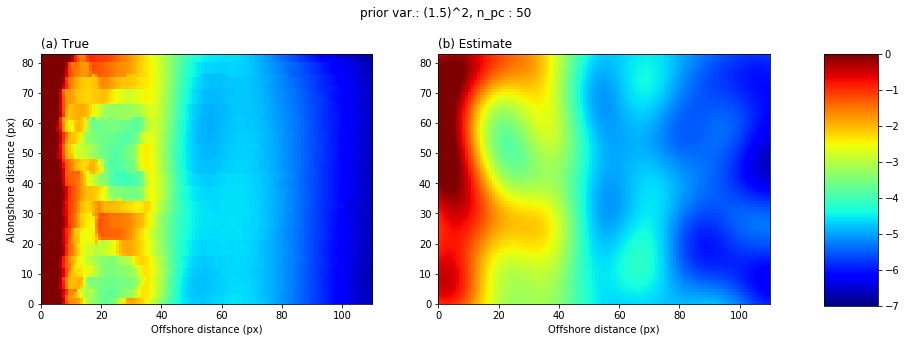

In [14]:
minv = s_true.min()
maxv = s_true.max()

fig, axes = plt.subplots(1,2, figsize=(15,5))
plt.suptitle('prior var.: (%g)^2, n_pc : %d' % (prior_std,params['n_pc']))
im = axes[0].imshow(np.flipud(np.fliplr(-s_true2d)), extent=[0, 110, 0, 83], vmin=-7., vmax=0., cmap=plt.get_cmap('jet'))
axes[0].set_title('(a) True', loc='left')
axes[0].set_aspect('equal')
axes[0].set_xlabel('Offshore distance (px)')
axes[0].set_ylabel('Alongshore distance (px)')
axes[1].imshow(np.flipud(np.fliplr(-s_hat2d)), extent=[0, 110, 0, 83], vmin=-7., vmax=0., cmap=plt.get_cmap('jet'))
axes[1].set_title('(b) Estimate', loc='left')
axes[1].set_xlabel('Offshore distance (px)')
axes[1].set_aspect('equal')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)


- plot transect at y = 25 px and 45 px

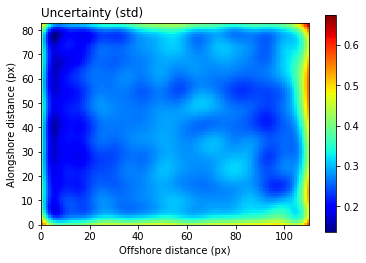

In [15]:
fig = plt.figure()
im = plt.imshow(np.flipud(np.fliplr(post_std2d)), extent=[0, 110, 0, 83], cmap=plt.get_cmap('jet'))
plt.title('Uncertainty (std)', loc='left')
plt.xlabel('Offshore distance (px)')
plt.ylabel('Alongshore distance (px)')
plt.gca().set_aspect('equal', adjustable='box')
fig.colorbar(im)


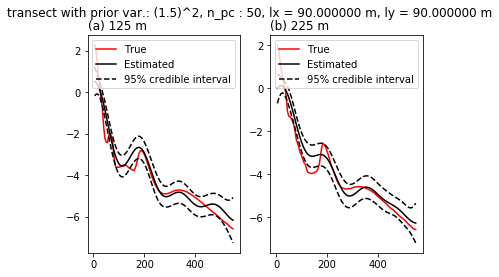

In [16]:

fig, axes = plt.subplots(1,2)
fig.suptitle('transect with prior var.: (%g)^2, n_pc : %d, lx = %f m, ly = %f m' % (prior_std, params['n_pc'],prior_cov_scale[0],prior_cov_scale[1]))

linex = np.arange(1,111)*5.0
line1_true = s_true2d[83-25+1,:]
line1 = s_hat2d[83-25+1,:]
line1_u = s_hat2d[83-25+1,:] + 1.96*post_std2d[83-25+1,:]
line1_l = s_hat2d[83-25+1,:] - 1.96*post_std2d[83-25+1,:]
#line1_X = Xbeta2d[83-25+1,:]

line2_true = s_true2d[83-45+1,:]
line2 = s_hat2d[83-45+1,:]
line2_u = s_hat2d[83-45+1,:] + 1.96*post_std2d[83-45+1,:]
line2_l = s_hat2d[83-45+1,:] - 1.96*post_std2d[83-45+1,:]
#line2_X = Xbeta2d[83-45+1,:]

axes[0].plot(linex, np.flipud(-line1_true),'r-', label='True')
axes[0].plot(linex, np.flipud(-line1),'k-', label='Estimated')
axes[0].plot(linex, np.flipud(-line1_u),'k--', label='95% credible interval')
axes[0].plot(linex, np.flipud(-line1_l),'k--')
#axes[0].plot(linex, np.flipud(-line1_X),'b--', label='Drift/Trend')
axes[0].set_title('(a) 125 m', loc='left')
#axes[0].set_title('(a) 25 px', loc='left')
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles, labels)

axes[1].plot(linex, np.flipud(-line2_true),'r-', label='True')
axes[1].plot(linex, np.flipud(-line2),'k-', label='Estimated')
axes[1].plot(linex, np.flipud(-line2_u),'k--', label='95% credible interval')
axes[1].plot(linex, np.flipud(-line2_l),'k--')
#axes[1].plot(linex, np.flipud(-line2_X),'b--', label='Drift/Trend')
axes[1].set_title('(b) 225 m', loc='left')
#axes[1].set_title('(b) 45 px', loc='left')
handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(handles, labels)

(-1.0, 9.0)

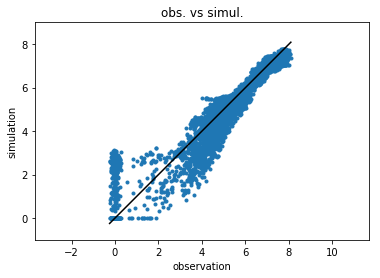

In [17]:
nobs = prob.obs.shape[0]
fig = plt.figure()
plt.title('obs. vs simul.')
plt.plot(prob.obs,simul_obs,'.')
plt.xlabel('observation')
plt.ylabel('simulation')
minobs = np.vstack((prob.obs,simul_obs)).min(0)
maxobs = np.vstack((prob.obs,simul_obs)).max(0)
plt.plot(np.linspace(minobs,maxobs,20),np.linspace(minobs,maxobs,20),'k-')
plt.axis('equal')
axes = plt.gca()
axes.set_xlim([math.floor(minobs),math.ceil(maxobs)])
axes.set_ylim([math.floor(minobs),math.ceil(maxobs)])

(-0.1, 2.1, 146864.7874545521, 257910.19258295928)

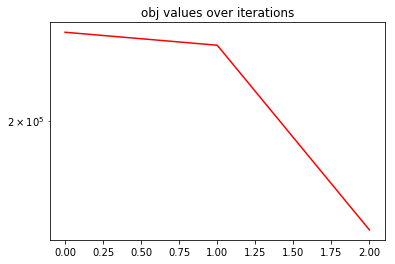

In [18]:
plt.semilogy(range(len(prob.objvals)),prob.objvals,'r-')
plt.title('obj values over iterations')
plt.axis('tight')

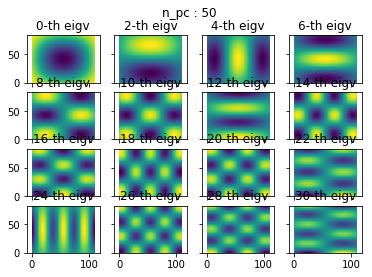

In [19]:
fig, axes = plt.subplots(4,4, sharex = True, sharey = True)
fig.suptitle('n_pc : %d' % params['n_pc'])
for i in range(4):
    for j in range(4):
        axes[i,j].imshow(prob.priorU[:,(i*4+j)*2].reshape(N[1],N[0]), extent=[0, 110, 0, 83])
        axes[i,j].set_title('%d-th eigv' %((i*4+j)*2))

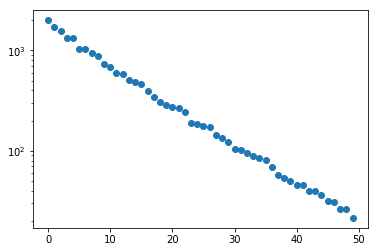

In [20]:
fig = plt.figure()
plt.semilogy(prob.priord,'o')